In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
sns.set()
%matplotlib inline

__autor__: Henrique Pougy - Supervisor Geral, STEL/CASE

# Previsao de Impacto - Deduplicação SLCe

## Contexto:

O _Sistema Eletrônico de Licenciamento de Construções_ (__SLCe__) "é uma ferramenta que permite que o cidadão licencie diversos tipos de obras, de pequeno e médio porte, totalmente de forma eletrônica" (http://bit.ly/slce-descricao). Trata-se do sistema de licenciamento edilício eletrônico da Prefeitura de São Paulo que tem por escopo, grosso modo, os projetos de menor porte, cuja competência de análise é delegada, pela Secretaria Municipal de Licenciamento, aos arquitetos e engenheiros lotados nas Subprefeituras do Munícipio de São Paulo.

Implementado ao final de 2012, ele se utiliza de duas ferramentas proprietárias da Microsoft: 

* o Dynamics CRM versão 2011, responsável pela aplicação propriamente dita; e 

* o SharePoint 2010 que, integrado ao Dynamics, é responsável pela persistência de dados. 

Ambas as ferramentas, que não foram originalmente concebidas para modelar o domínio do licenciamento edilício, foram extensamente customizadas para atender às necessidades de modelagem das atividades de licenciamento edilício da Prefeitura no sistema. Tais customizações, ainda que inicialmente funcionais, têm hoje demonstrado sérios problemas de escalabilidade.

## O Problema:

Uma dessas customizações diz respeito à uma funcionalidade de versionamento dos arquivos das solicitações realizadas no sistema. Basicamente, toda as vezes em que são realizados dois tipos de ação no sistema pelos usuários da Prefeitura - _"Análise da Solicitação"_ e _"Análise de Requisitos Básicos"_ - são criados novos lotes de arquivos no SharePoint relacionados a essas solicitações. O objetivo destes lotes de arquivos é registrar, como um _snapshot_, a situação exata da documentação relacionada ao processo quando da realização destas ações.

No entanto, tais _snapshots_ não são realizados por meio do registro de _hyperlinks_ apontando aos arquivos originais, quando não há modificação nos mesmos. Com efeito eles __geram a duplicação de todos os arquivos que compõem a documentação da solicitação a cada novo lote, replicando todo o seu conteúdo__. Neste cenário, uma solicitação que foi analisada 6 vezes, terá todos os seus arquivos originais (plantas em .dwf, digitalizações dos documentos do requerente etc.) replicados por 5 vezes no sistema.

São evidentes as limitações de escalabilidade que essa solução possui. Com efeito, ao longo dos anos, a volumetria ocupada pelo SharePoint cresceu vertiginosamente, __ultrapassando de forma preocupante o valor máximo recomendado pela Microsoft__ (http://bit.ly/limites_Sharepoint), alcançando mais de 4 TeraBytes de dados.

## Objetivos deste _report_

Este _report_ tem por objetivo principal realizar uma __previsão de impacto, baseada em evidências, de uma ação de deduplicação dos arquivos do SLCe__. Ele busca avaliar e sensibilizar os tomadores de decisão sobre os possíveis benefícios de tal ação - que, como veremos ao final, são elevados.

O _report_ se vale de uma base de dados extraída em 2018, em formato .xlsx, que tinha por objetivo original gerar um relatório gerencial de produtividade dos servidores da PMSP no sistema. Para isso, o autor do relatório gerencial construiu indicadores relacionados à quantidade de ações realizadas por usuário em um determinado período de tempo, a duração dessas ações, entre outras informações. Para construção dos gráficos e indicadores ali presentes, foram utilizados os dados relacionados à todas as ações realizadas no sistema por usuários da Prefeitura à época, extraídos do banco de dados do sistema em 2018.

Por sorte - e confirmando aqui o valor dessa boa prática - os microdados que fundamentaram o report foram adicionados ao arquivo. É com base neles que desenvolvemos estes report. Estes mesmos microdados são disponibilizados, após remoção de dados pessoais e padronização do formato, no arquivo "dados_limpos.xlsx" que consta neste repositório.

## Metodologia

Os microdados das ações realizadas no sistema pelos usuários da PMSP no período compreendido entre outubro de 2012 e agosto de 2018 são aqui analisados para identificar e quantificar com precisão __todas as ações realizadas no sistema neste período que geraram duplicação de arquivos__. Isto requer a realização de diversas filtragens nos dados originais, para garantir que se tratam de fato de:

* Ações que foram realizadas sobre processos digitais (e não processos em papel);
* Que foram feitas sobre processos que foram protocolados com sucesso (e não em rascunho, cancelados etc.);
* Que estão dentre as ações que de fato geram duplicação (conforme mencionado acima); e,
* Por fim, que foram ações de fato concluídas, e não apenas iniciadas ou canceladas;

Uma vez realizada a filtragem no _dataset_ original, realizamos em seguida uma análise estatística descritiva simples. Esta análise permite entender melhor como se dá a distribuição das duplicações de dados nos protocolos do sistema. Os principais resultados desta análise são a quantidade média de ações que geram duplicação por solicitação no sistema, além da proporção da quantidade de arquivos originais em relação aos duplicados.

Em seguida, realizamos uma projeção da quantidade de ações que geram duplicação de arquivos no sistema em função do tempo. Esta projeção, obtida através da modelagem estatística dos dados (Regressão Linear Simples), que obteve alto coeficiente de determinação e significância estatística, permite estimar a quantidade de lotes de arquivos a serem afetados por uma desduplicação a ser realizada hoje.


## Resultados encontrados:

__Mediana de ações que geram duplicação por protocolo__ : 2 por protocolo

__Proporção do banco de dados desduplicado__ : aprox. 40% da volumetria de armazenagem de arquivos em 2018

__Estimativa de lotes a serem afetados pela desduplicação__ : aprox. 100 mil lotes

Conforme dados apresentandos acima, este _report_ conclui que a ação de deduplicação de arquivos no sistema SLCe será altamente benéfica. Ela é, portanto, __altamente recomendada__.

## Limpeza e preparação dos dados

Na célula abaixo carregamos e limpamos os dados brutos, provenientes de um relatório de gestão de 2018 do sistema (que não salvaremos no repositório por conter dados pessoais/sensíveis).

In [3]:
def load_and_clean_data():
    
    df = pd.read_excel('SLCe_Histórico_Atividades_10AGO2018.xlsm', sheet_name = 'Base de Dados', dtype = 'object')
    
    #converter colunas para datetime
    dtimes = [
    'Data de Início da atividade',
    'Data de Conclusão da atividade',
    'Data de Abertura do Processo',
    'Data de Publicação do Despacho',
         ]
    for series in dtimes:
        df[series] = pd.to_datetime(df[series], errors = 'coerce')
        
    #remover sujeira da planilha
    unnameds = [col for col in df.columns if col.startswith('Unnamed')]
    df.drop(unnameds, axis = 1, inplace = True)
    
    #coloca numero de protocolo como string
    df['Número do Protocolo'] = df['Número do Protocolo'].astype(str)
    
    #remover os nomes dos usuários
    dados_pessoais = ['Usuário da tarefa']
    df.drop(dados_pessoais, axis=1, inplace = True)
    
    #podemos recalcular essa coluna depois
    df.drop('Tempo da Atividade', axis = 1, inplace = True)
    
    #acho util sempre criar uma coluna de contador
    df['count'] = 1
    
    return df

Como podemos notar, o dataset original possui mais de 250 mil registros, todos eles correspondendo a ações realizadas por usuários da Prefeitura no SLCe, ocorridas no período compreendido entre outubro de 2012 e agosto de 2018.

In [4]:
#df = load_and_clean_data()
#df.to_excel('dados_limpos.xlsx', index = False)
df = pd.read_excel('dados_limpos.xlsx')
print(f'Ao todo são {len(df)} registros')
dt_ini = df['Data de Início da atividade'].min()
print(f'A data de inicio do dataset é {dt_ini}')
dt_ini = df['Data de Início da atividade'].min()
print(f'A data de inicio do dataset é {dt_ini}')

Ao todo são 250725 registros
A data de inicio do dataset é 2012-10-09 00:00:00
A data de inicio do dataset é 2012-10-09 00:00:00


In [5]:
df.head()

,Data de Início da atividade,Data de Conclusão da atividade,Status da Atividade,Tipo de Atividade,Número do Processo,Data de Abertura do Processo,Número do Protocolo,Assunto,Situação da Solicitação,Competência,Unidade Administrativa,Tipo da Solicitação,Data de Publicação do Despacho,Ano/Mês Data de Início da Atividade,Papelizados,count
0,2012-10-09,2012-10-31,Concluída,Busca de BDT,2012-0.290.531-1,2012-10-09,248-12,Alvará de Aprovação de Edificação Nova,Indeferido,SMPR,Prefeitura Regional Ipiranga,Inicial,2014-10-24,2012 10,Não Papelizado,1
1,2012-10-10,2012-10-29,Concluída,Busca de BDT,2012-0.291.510-4,2012-10-10,647-12,Alvará de Licença para Residências Unifamiliares,Indeferido,SMPR,Prefeitura Regional Aricanduva - Formosa - Carrão,Inicial,2013-06-19,2012 10,Não Papelizado,1
2,2012-10-10,2013-01-17,Concluída,Busca de BDT,2012-0.291.511-2,2012-10-10,79-12,Alvará de Aprovação de Reforma,Indeferido,SMPR,Prefeitura Regional Sé,Inicial,2014-03-07,2012 10,Não Papelizado,1
3,2012-10-10,2012-10-30,Concluída,Busca de BDT,2012-0.291.512-0,2012-10-10,523-12,Alvará de Aprovação de Edificação Nova,Deferido,SMPR,Prefeitura Regional Mooca,Inicial,2014-10-31,2012 10,Não Papelizado,1
4,2012-10-10,2012-10-30,Concluída,Busca de BDT,2012-0.291.513-9,2012-10-10,660-12,Alvará de Aprovação de Edificação Nova,Indeferido,SMPR,Prefeitura Regional Penha,Inicial,2013-10-03,2012 10,Não Papelizado,1


Na celula abaixo, definimos as funcoes que filtram o _dataset_. Tal tarefa é necessária para que possamos identificar especificamente todas as __ações que geraram duplicação de lotes de arquivos no sistema__. Para isso, identificamos:

* Todas as ações realizadas sobre processos inteiramente digitais ("não-papelizados", nos termos do _dataset_);
* Que foram feitas sobre protocolos válidos (isto é, que não são de processos físicos, que não foram cancelados e que tampouco estão "em rascunho");
* Que estão entre as ações que geram duplicação de arquivos ('Análise da Solicitação' e 'Análise de Requisitos Básicos'); e
* Por fim, que foram devidamente concluídas no sistema

As funções abaixo realizam a identificação de tais ações. Elas são aplicadas ao _dataset_ em seguida.

In [6]:
def apenas_atividades_concluidas(df):
    

    atividades_concluidas = df['Status da Atividade']=='Concluída'
    df = df[atividades_concluidas].copy().reset_index(drop=True)
    
    return df

def atividades_geram_duplicacao(df):
    
    atividades_duplicacao = [
    'Análise da Solicitação',
    'Análise de Requisitos Básicos'
    ]

    filtro_atividade = df['Tipo de Atividade'].isin(atividades_duplicacao)
    
    df = df[filtro_atividade].copy().reset_index(drop=True)
    
    return df

def situacoes_protocolo_corretas(df):
    
    situacoes_ruins = [
            'Em Rascunho',
            'Processo Físico',
            'Cancelado',
    ]

    filtro_situacao = ~df['Situação da Solicitação'].isin(situacoes_ruins)

    df = df[filtro_situacao].copy().reset_index(drop=True)
    
    return df

def nao_papelizado(df):
    
    filtro_papelizado = df['Papelizados']!='Processo Papelizado'
    
    df = df[filtro_papelizado].copy().reset_index(drop=True)
    
    return df

In [7]:
#abaixo as funções acima definidas são chamadas em cadeia

df = apenas_atividades_concluidas(
    atividades_geram_duplicacao(
        situacoes_protocolo_corretas(
            nao_papelizado(df)
            )
        )
    )
print('Tipos de atividade no dataset: ' + ', '.join(df['Tipo de Atividade'].unique()))
df.head()

Tipos de atividade no dataset: Análise da Solicitação, Análise de Requisitos Básicos


,Data de Início da atividade,Data de Conclusão da atividade,Status da Atividade,Tipo de Atividade,Número do Processo,Data de Abertura do Processo,Número do Protocolo,Assunto,Situação da Solicitação,Competência,Unidade Administrativa,Tipo da Solicitação,Data de Publicação do Despacho,Ano/Mês Data de Início da Atividade,Papelizados,count
0,2012-10-18,2013-02-07,Concluída,Análise da Solicitação,2012-0.292.421-9,2012-10-10,663-12,Alvará de Aprovação de Edificação Nova,Indeferido,SMPR,Prefeitura Regional do Butantã,Inicial,2013-10-19,2012 10,Não Papelizado,1
1,2012-10-23,2012-11-01,Concluída,Análise da Solicitação,2012-0.292.446-4,2012-10-10,419-12,Alvará de Aprovação de Reforma,Deferido,SMUL,RESID,Inicial,2012-12-29,2012 10,Não Papelizado,1
2,2012-10-24,2013-07-30,Concluída,Análise da Solicitação,2012-0.297.055-5,2012-10-17,539-12,Alvará de Aprovação de Edificação Nova,Indeferido,SMPR,Prefeitura Regional Freguesia do Ó - Brasilandia,Inicial,2014-02-21,2012 10,Não Papelizado,1
3,2012-10-24,2012-11-01,Concluída,Análise da Solicitação,2012-0.296.832-1,2012-10-16,393-12,Alvará de Aprovação de Edificação Nova,Deferido,SMUL,SERVIN,Inicial,2012-12-27,2012 10,Não Papelizado,1
4,2012-10-24,2013-08-27,Concluída,Análise da Solicitação,2012-0.297.053-9,2012-10-17,278-12,Alvará de Aprovação de Reforma,Indeferido,SMUL,RESID,Inicial,2016-07-05,2012 10,Não Papelizado,1


No entanto, apesar da filtragem realizada acima, permanece um problema, que indica uma inconsistência de dados no _dataset_: há um percentual (menos de 5%) de ações que, ainda que tenha sido conluídas no sistema, possuem o parâmetro de "Data de Conclusão" como nulo. Decidimos remover tais registros do _dataset_.

In [8]:
atividades__concluidas_sem_dt_conclusao = (df['Data de Conclusão da atividade'].isnull())&(df['Status da Atividade']=='Concluída')
prop_sem_dt = atividades__concluidas_sem_dt_conclusao.sum()/len(df)
print(f'Proporção de atividades concluídas sem data é de {prop_sem_dt}')
df[atividades__concluidas_sem_dt_conclusao].head()


Proporção de atividades concluídas sem data é de 0.04637437485524092


,Data de Início da atividade,Data de Conclusão da atividade,Status da Atividade,Tipo de Atividade,Número do Processo,Data de Abertura do Processo,Número do Protocolo,Assunto,Situação da Solicitação,Competência,Unidade Administrativa,Tipo da Solicitação,Data de Publicação do Despacho,Ano/Mês Data de Início da Atividade,Papelizados,count
396,2013-01-07,NaT,Concluída,Análise da Solicitação,2012-0.355.875-5,2012-12-21,6175-12,Alvará de Desdobro de Lote,Indeferido,SMPR,Prefeitura Regional Mooca,Inicial,2018-03-30,2013 01,Não Papelizado,1
1803,2013-04-15,NaT,Concluída,Análise da Solicitação,2013-0.103.678-8,2013-04-11,6349-13,Alvará de Aprovação de Edificação Nova,Indeferido,SMPR,Prefeitura Regional Lapa,Inicial,2018-02-27,2013 04,Não Papelizado,1
2971,2013-06-07,NaT,Concluída,Análise da Solicitação,2013-0.159.982-0,2013-06-06,10273-13,Alvará de Aprovação de Edificação Nova,Indeferido,SMPR,Prefeitura Regional Ermelino Matarazzo,Inicial,2018-04-10,2013 06,Não Papelizado,1
2988,2013-06-07,NaT,Concluída,Análise da Solicitação,2013-0.159.997-9,2013-06-06,10374-13,Alvará de Aprovação de Edificação Nova,Processando Comunique-se,SMPR,Prefeitura Regional Ermelino Matarazzo,Inicial,NaT,2013 06,Não Papelizado,1
3169,2013-06-14,NaT,Concluída,Análise da Solicitação,2013-0.167.372-9,2013-06-13,10148-13,Alvará de Aprovação de Edificação Nova,Indeferido,SMPR,Prefeitura Regional Ermelino Matarazzo,Inicial,2018-02-08,2013 06,Não Papelizado,1


In [9]:
#abaixo, filtramos o dataset, removendo as ações concluidas sem data de conclusão
df = df[~atividades__concluidas_sem_dt_conclusao].copy().reset_index(drop = True)
print(f'O tamanho final do dataset é {len(df)} registros.')

O tamanho final do dataset é 111167 registros.


# Análise I - Quantidade esperada de duplicações por protocolo

Uma vez obtido o _dataset_ que contém os dados que desejamos, isto é, _a relação de todas as ações realizadas no  SLCe por usuários da Prefeitura, ocorridas no período entre outubro de 2012 e agosto de 2018, e que acarretaram em duplicação de arquivos no sistema_, podemos prosseguir para a análise. Neste primeiro bloco, procederemos à agregação da quantidade de ações que geraram duplicação por protocolo do sistema. Com isso, buscamos identificar uma medida que nos permita definir uma quantidade esperada de duplicações por protocolo.

Abaixo, seleiconameos apenas as colunas de "Número de Protocolo" e o contador "count", que vale 1 para todos os registros. O _dataset_ assim filtrado é então agregado por protocolo, identificando a quantidade exata de ações que geraram duplicação realizadas para cada protocolo no período considerado.

In [10]:
qtd_atividades_protocolo = df[['Número do Protocolo', 'count']].groupby('Número do Protocolo').count()
qtd_atividades_protocolo.sort_values(by = 'count', ascending = False).head()


,count
Número do Protocolo,
32638-15,33
6561-12,32
9913-13,30
5922-13,27
9924-13,27


In [11]:
qtd_atividades_protocolo.sort_values(by = 'count', ascending = False).tail()

,count
Número do Protocolo,
36025-15,1
24121-15,1
36022-16,1
24122-15,1
17258-17,1


Notamos que há, com efeito, protocolos que tiveram quantidade elevada de duplicações, enquanto outros possuem apenas uma. Cumpre nos aprofundar nas estatísticas descritivas para compreender melhor esta distribuição. Como veremos abaixo, essa distribuição não se aproxima de uma distribuição normal, sendo necessário utilizar outras medidas de tendência central que não a média para se aproximar de um valor esperado da quantidade de duplicações por protocolo.

In [12]:
descritivo = qtd_atividades_protocolo.describe()

In [13]:
descritivo

,count
count,43080.000000
mean,2.580478
std,2.080803
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,33.000000


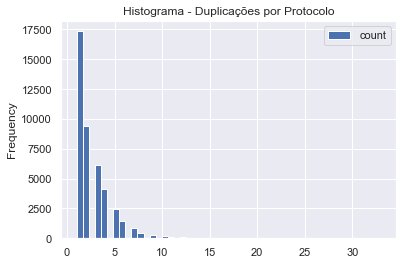

In [14]:
qtd_atividades_protocolo.plot.hist(bins = 50, title = 'Histograma - Duplicações por Protocolo')

As estatísticas descritivas e o histograma apresentado acima indicam que se trata de uma distribuição assimétrica, que não se aproxima da curva normal. 

In [15]:
c = qtd_atividades_protocolo['count']

In [16]:
c.value_counts()

1     17354
2      9376
3      6146
4      4102
5      2445
6      1484
7       871
8       474
9       292
10      195
11      111
12       74
13       45
14       28
15       20
16       18
17        8
18        7
20        7
19        5
22        5
21        3
27        2
25        2
26        2
33        1
30        1
24        1
32        1
Name: count, dtype: int64

Text(0.5, 1.0, 'BoxPlot - Duplicações por Protocolo')

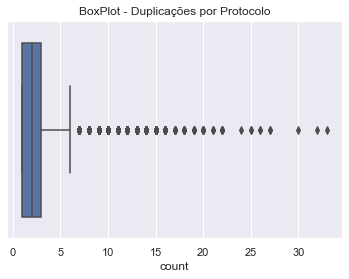

In [17]:
sns.boxplot(c).set_title('BoxPlot - Duplicações por Protocolo')

A hipótese aventada acima é corroborada pelo olhar mais detalhado aos _value counts_ do _dataset_, assim como pela análise do _boxplot_, que indica alta concentração à esquerda do eixo horizontal, com valores maiores que zero mais próximo dele, e uma quantidade elevada de outliers á direita neste eixo.

Abaixo, realizamos os testes estatísticos para confirmar a hipótese de que se trata de uma distribuição assimétrica, não-normal.

In [18]:
from scipy.stats import kurtosis, skew, normaltest

In [19]:
kurtosis(c)

12.419819677384854

In [20]:
skew(c)

2.502917309230294

In [21]:
normaltest(c)

NormaltestResult(statistic=24605.116993127573, pvalue=0.0)

Conforme resultado do teste acima, com um p-valor próximo a zero, podemos então rejeitar a hipótese nula de que a distribuição é normal.

De fato, conforme perfil visualisado no histograma, trata-se de uma distribuição assimétrica positiva platicúrtiva, de perfil do tipo "calda longa" positiva.

Assim, podemos concluir que a medida de tendência central mais adequada ao tipo de distribuição não é a média, mas a __mediana__, que é apresentada abaixo.

In [22]:
esperado = c.median()
print(f'Concluímos, portanto, que o valor esperado de ações que geram duplicações por protocolo é {esperado}')

Concluímos, portanto, que o valor esperado de ações que geram duplicações por protocolo é 2.0


Se considerarmos que a primeira dessas ações registra o _snapshot_ inicial dos arquivos, enquanto todas as ações subsequentes resultam na replicação do conteúdo dos mesmos, isso significa que __cada protocolo no SLCe tende a ocupar o _dobro de espaço em disco_, no que diz respeito à armazenagem de arquivos, do que deveria__.

## Análise 2 - Taxa de duplicação estimada do banco de dados (armazenagem de arquivos)

Uma vez identificada a quantidade esperada de duplicações por protocolo, podemos prosseguir à próxima etapa da análise.

Neste bloco, buscamos estimar a taxa de duplicação do banco de dados. Nosso objeto de análise é, nesta etapa, a armazenagem de arquivos do banco de dados como um todo, e não mais os protocolos individuais.  A lógica que subjaz esta análise se baseia nas seguintes pré-condições, confirmadas pela equipe de SLCe:

* Todas as ações constantes no _dataset_ aqui utilizado geraram duplicações de arquivos no banco de dados;
* Nenhum arquivo anexado a um protocolo pode ser removido/deletado do banco de dados, apenas novos arquivos podem ser acrescentados;
* Todo protocolo que foi protocolado com sucesso no sistema contém uma quantidade X de arquivos iniciais, que serão mantidos no banco de dados ao longo da análise (e duplicados sempre que ocorrerem as ações aqui consideradas).

Deste modo, podemos identificar uma quantidade - identificada pela variável _qtd_originais_ -  que corresponde à quantidade total de lotes de arquivos originais por protocolo. Não nos importa aqui a quantidade exata de arquivos originais por protocolo, tampouco o volume dos mesmos: o que observamos é que há um conjunto, cujo número de membros é identificado pela variável _qtd_originais_, que corresponde aos lotes de arquivos originais de cada protocolo. Como todo protocolo que foi protocolado no sistema deve conter um - e apenas um -  lote de arquivos iniciais, este conjunto corresponde à __quantidade de protocolos únicos protocolados no sistema__.

Para identificarmos as replicações que ocorreram no sistema no período da análise (out/2012 a ago/2018), basta subtrair, da quantidade total de ações que geraram duplicações (variável _qtd_duplicadas_ - que corresponde também ao total de lotes de arquivos no sistema), a quantidade de lotes de arquivos originais, identificava pela variável _qtd_originais_. É com base nesta metodologia que os cálculos abaixo são realizados.





In [23]:
total_acoes = len(df)

In [24]:
qtd_originais = len(df['Número do Protocolo'].unique())

print(f'A quantidade de lotes de arquivos originais é  de {qtd_originais} lotes')

A quantidade de lotes de arquivos originais é  de 43080 lotes


In [25]:
qtd_duplicadas = total_acoes-qtd_originais
print(f'A quantidade de lotes que contém arquivos replicados no banco de dados é de {qtd_duplicadas} lotes')

A quantidade de lotes que contém arquivos replicados no banco de dados é de 68087 lotes


In [26]:
prop_duplicadas = qtd_duplicadas/total_acoes
print(f'A proporção de lotes duplicados sobre o total de lotes no banco de dados é de {prop_duplicadas:.2%}')

A proporção de lotes duplicados sobre o total de lotes no banco de dados é de 61.25%


In [27]:
prop_arquivos_unicos = qtd_originais/total_acoes
print(f'A proporção de lotes com arquivos originais sobre o total de lotes no banco de dados é de {prop_arquivos_unicos:.2%}')

A proporção de lotes com arquivos originais sobre o total de lotes no banco de dados é de 38.75%


In [28]:
(prop_arquivos_unicos + prop_duplicadas) == 1

True

Desta forma, podemos concluir que, caso seja realizada a deduplicação do banco de dados, este tende a __ser reduzido a menos de 40% de seu volume atual__.

## Análise 3 - Projeção da quantidade de lotes atual e previsão do total de lotes a ser afetado pela desduplicação

Nesta seção, realizamos uma análise de série temporal, identificando a tendência de crescimento, ao longo do tempo, do total de lotes de arquivos no banco de dados do sistema SLCe. Para isso, construímos a série temporal com a quantidade acumulada de ações de replicação ao longo do tempo, no período compreendido entre outubro de 2012 e agosto de 2018.

Sobre esta série temporal, projetamos uma regressão linear simples. O modelo ajustado, que possui significância estatística, é então utilizado para prever o total de lotes de arquivos no sistema hoje.

Este total de lotes é, por fim, multiplicado pela proporção de lotes duplicados no período 2012-2018, conforme seção anterior, para gerar uma _proxy_ da quantidade total de lotes de arquivos a ser afetada pela desduplicação.

Nas células abaixo, ordenamos o _dataset_ a partir da "Data de Conclusão" das atividades.
Em seguida, agrupamos a quantidade de atividades realizadas por dia e geramos uma variável no _dataset_ que contém a soma cumulativa da quantidade de ações de replicações (que é, por sua vez, igual à quantidade de lotes de arquivos) no sistema ao longo do tempo.

Essa série temporal é então plotada, revelando uma clara linha de tendência.

In [29]:
df.sort_values(by = 'Data de Conclusão da atividade', inplace = True)
df.reset_index(drop = True, inplace = True)

In [30]:
atividades_dia = df.groupby('Data de Conclusão da atividade').count()[['count']]

In [31]:
atividades_dia['replicacoes_cumulativas'] = atividades_dia['count'].cumsum()

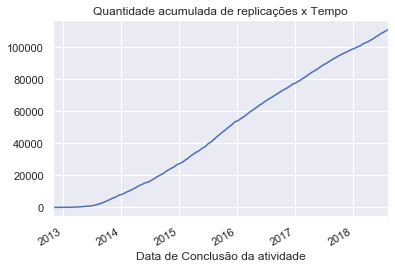

In [32]:
atividades_dia['replicacoes_cumulativas'].plot(title = 'Quantidade acumulada de replicações x Tempo')

Nas células abaixo, criamos uma nova variável no _dataset_ da série temporal criado anteriormente. Esta variável busca representar a quantidade de dias passados desde o primeiro registro da base de dados até o dia de conclusão da ação em questão.

In [33]:
atividades_dia['dias_passados'] = 0
primeiro_dia = atividades_dia.index.min()
for i, row in atividades_dia.iterrows():
    atividades_dia.loc[i, 'dias_passados'] = (i - primeiro_dia).days

In [34]:
#abaixo, checamos para ver se o cálculo foi feito corretamente
((df['Data de Conclusão da atividade'].max() - df['Data de Conclusão da atividade'].min()).days) == atividades_dia.iloc[-1]['dias_passados']

True

Abaixo, é realizada a modelagem estatística (Regressão Linear Simples). Como se pode notar, a modelagem é um sucesso, alcançando significância estatística (p-valor próximo a 0) e um excelente coeficiente de determinação (99%).

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import linregress

Para calcular a significância estatística de um modelo linear para os dados em questão, utilizamos uma abordagem da estatística clássica, implementada no módulo scipy.

In [36]:
_, _, _, p_value, _ = linregress(atividades_dia['dias_passados'],
                                                         atividades_dia['replicacoes_cumulativas'])

print(f'Pelos métodos estatísticos clássicos, a regressão linear possui p-valor {p_value}')

if p_value < 0.001:
    print('A modelagem possui significância estatística')

Pelos métodos estatísticos clássicos, a regressão linear possui p-valor 0.0
A modelagem possui significância estatística


Em seguida, para realizar o ajuste do modelo propriamente dito, utilizamos técnicas mais modernas de machine learning. Como se pode ver, o modelo encontra excelente performance nos dados de teste, com um alto coeficiente de determinação (99%).

In [37]:
X_train, X_test, y_train, y_test = train_test_split(np.array(atividades_dia['dias_passados']).reshape(-1, 1)
                                                    , np.array(atividades_dia['replicacoes_cumulativas']), 
                                                    test_size=0.33, random_state=42)

In [38]:
regr = LinearRegression(fit_intercept=True)
regr.fit(X=X_train,
         y = y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('O coeficiente linear é: \n', regr.coef_[0])
# The mean squared error
print('O erro absoluto médio é: %.2f'
      % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('O coeficiente de determinação é: %.2f'
      % r2_score(y_test, y_pred))


O coeficiente linear é: 
 59.5903548185481
O erro absoluto médio é: 2721.11
O coeficiente de determinação é: 0.99


A boa performance do modelo pode ser visualizada na plotagem abaixo, que compara a predição do modelo (em vermelho) com os dados de teste originais (em azul).

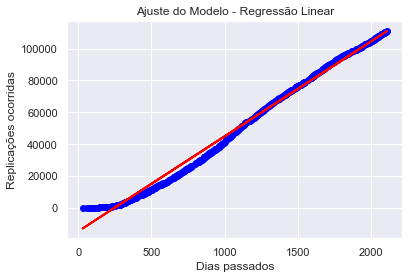

In [40]:
# Abaixo, vamos plotar o ajuste do modelo aos dados de teste
plt.scatter(X_test, y_test,  color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel('Dias passados')
plt.ylabel('Replicações ocorridas')
plt.title('Ajuste do Modelo - Regressão Linear')
plt.show()

Uma vez comprovada a validade do modelo, seguimos para a projeção: aqui, buscamos projetar a quantidade total de lotes de arquivo no sistema atualmente.

Text(0.5, 1.0, 'Projeção - Lotes de arquivos no sistema hoje')

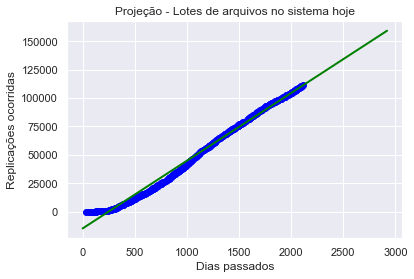

In [41]:
hoje = pd.to_datetime("today").date()
dias_ate_hoje = (hoje - dt_ini.date()).days
array_dias_ate_hoje = np.array([i for i in range(0, dias_ate_hoje)]).reshape(-1, 1)
predict_ate_hoje = regr.predict(array_dias_ate_hoje)
plt.scatter(X_test, y_test,  color='blue')
plt.xlabel('Dias passados')
plt.ylabel('Replicações ocorridas')
plt.plot(array_dias_ate_hoje, predict_ate_hoje, color='green', linewidth=2)
plt.title('Projeção - Lotes de arquivos no sistema hoje')

In [42]:
lotes_hoje = round(predict_ate_hoje[-1])
print(f'O total projetado de lotes de arquivos no sistema hoje é de {lotes_hoje}')

O total projetado de lotes de arquivos no sistema hoje é de 159250.0


Como vimos anteriormente, a proporção de lotes duplicados no sistema é de aproximadamente 60%.Para identificar a quantidade estimada de lotes que serão afetados pela desduplicação, multiplicamos então a quantidade projetada de lotes pela proporção de lotes duplicados no sistema. 

In [43]:
round(lotes_hoje * prop_duplicadas)

97537.0

Vemos assim que aproximadamente 100 mil lotes serão afetados pela desduplicação.